## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

C:\Users\peteryu\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.regularizers import l1, l2, l1_l2

def build_l1_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def build_l1_l2_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4, l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1_ratio, l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_ratio, l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [15]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [0.01, 0.001]
L2_EXP = [0.01, 0.001]

In [16]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_l1_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

for regulizer_ratio_l1 in L1_EXP:    
    for regulizer_ratio_l2 in L2_EXP:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
        model = build_l1_l2_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio_l1, l2_ratio=regulizer_ratio_l2)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        exp_name_tag = "exp-l1_l2-l1:%s-l2:%s" % (str(regulizer_ratio_l1), str(regulizer_ratio_l2))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 83us/step - loss: 39.3507 - acc: 0.2727 - val_loss: 36.0155 - val_acc: 0.3382
Epoch 2/50
50000/50000 [==============================] - 4s 74us/step - loss: 32.9852 - acc: 0.3613 - val_loss: 30.0220 - val_acc: 0.3759
Epoch 3/50
50000/50000 [==============================] - 4s 74us/step - loss: 27.3253 - acc: 0.3831 - val_loss: 24.6917 - val_acc: 0.3917
Epoch 4/50
50000/50000 [==============================] - 4s 74us/step - loss: 22.3149 - acc: 0.3938 - val_loss: 20.0020 - val_acc: 0.3957
Epoch 5/50
50000/50000 [==============================] - 4s 74us/step - loss: 17.9400 - acc: 0.4003 - val_loss: 15.9488 - val_acc: 0.3993
Epoch 6/50
50000/50000 [==============================] - 4s 74us/step - loss: 14.1968 - acc: 0.4008 - val_loss: 12.5226 - val_acc: 0.4032
Epoch 7/50
50000/50000 [==============================] - 4s 74us/step - loss: 11.0877 - acc: 0.4015 - val_loss: 9.7

50000/50000 [==============================] - 5s 90us/step - loss: 197.7851 - acc: 0.2211 - val_loss: 35.9531 - val_acc: 0.2535
Epoch 2/50
50000/50000 [==============================] - 4s 77us/step - loss: 15.9086 - acc: 0.1107 - val_loss: 5.1361 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 4s 77us/step - loss: 3.2139 - acc: 0.0984 - val_loss: 2.4716 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 4s 77us/step - loss: 2.4632 - acc: 0.0988 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 4s 77us/step - loss: 2.4624 - acc: 0.0963 - val_loss: 2.4623 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 4s 77us/step - loss: 2.4624 - acc: 0.0986 - val_loss: 2.4623 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 4s 77us/step - loss: 2.4623 - acc: 0.0970 - val_loss: 2.4622 - val_acc: 0.1000
Epoch 8/50
50000/50000 [========================

50000/50000 [==============================] - 4s 78us/step - loss: 18.7563 - acc: 0.1167 - val_loss: 7.0172 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 4s 79us/step - loss: 3.9875 - acc: 0.0994 - val_loss: 2.6052 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 4s 78us/step - loss: 2.4793 - acc: 0.0996 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 4s 78us/step - loss: 2.4626 - acc: 0.0971 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 4s 78us/step - loss: 2.4626 - acc: 0.0985 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 4s 78us/step - loss: 2.4626 - acc: 0.0962 - val_loss: 2.4623 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 4s 79us/step - loss: 2.4626 - acc: 0.0967 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 9/50
50000/50000 [===========================

50000/50000 [==============================] - 4s 77us/step - loss: 26.9527 - acc: 0.3593 - val_loss: 22.5537 - val_acc: 0.3597
Epoch 4/50
50000/50000 [==============================] - 4s 77us/step - loss: 18.9157 - acc: 0.3629 - val_loss: 15.5493 - val_acc: 0.3563
Epoch 5/50
50000/50000 [==============================] - 4s 77us/step - loss: 12.8445 - acc: 0.3586 - val_loss: 10.3898 - val_acc: 0.3545
Epoch 6/50
50000/50000 [==============================] - 4s 77us/step - loss: 8.5219 - acc: 0.3516 - val_loss: 6.8901 - val_acc: 0.3411
Epoch 7/50
50000/50000 [==============================] - 4s 77us/step - loss: 5.7777 - acc: 0.3384 - val_loss: 4.8791 - val_acc: 0.3234
Epoch 8/50
50000/50000 [==============================] - 4s 77us/step - loss: 4.3519 - acc: 0.3170 - val_loss: 3.9379 - val_acc: 0.3067
Epoch 9/50
50000/50000 [==============================] - 4s 78us/step - loss: 3.6339 - acc: 0.3072 - val_loss: 3.3575 - val_acc: 0.3009
Epoch 10/50
50000/50000 [=====================

50000/50000 [==============================] - 4s 77us/step - loss: 22.1232 - acc: 0.3869 - val_loss: 19.6779 - val_acc: 0.3930
Epoch 5/50
50000/50000 [==============================] - 4s 77us/step - loss: 17.5114 - acc: 0.3936 - val_loss: 15.4290 - val_acc: 0.3992
Epoch 6/50
50000/50000 [==============================] - 4s 77us/step - loss: 13.6219 - acc: 0.3958 - val_loss: 11.9027 - val_acc: 0.4000
Epoch 7/50
50000/50000 [==============================] - 4s 77us/step - loss: 10.4535 - acc: 0.3950 - val_loss: 9.1036 - val_acc: 0.3936
Epoch 8/50
50000/50000 [==============================] - 4s 77us/step - loss: 8.0071 - acc: 0.3916 - val_loss: 7.0371 - val_acc: 0.3705
Epoch 9/50
50000/50000 [==============================] - 4s 77us/step - loss: 6.2868 - acc: 0.3812 - val_loss: 5.6864 - val_acc: 0.3644
Epoch 10/50
50000/50000 [==============================] - 4s 77us/step - loss: 5.2359 - acc: 0.3690 - val_loss: 4.8942 - val_acc: 0.3594
Epoch 11/50
50000/50000 [===================

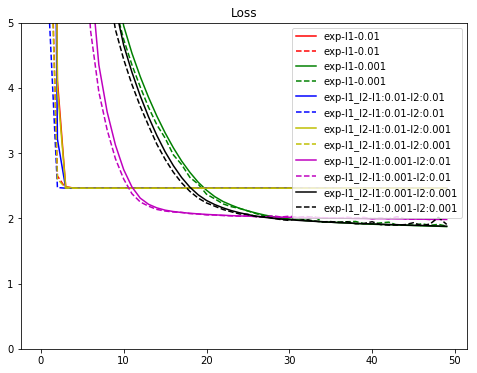

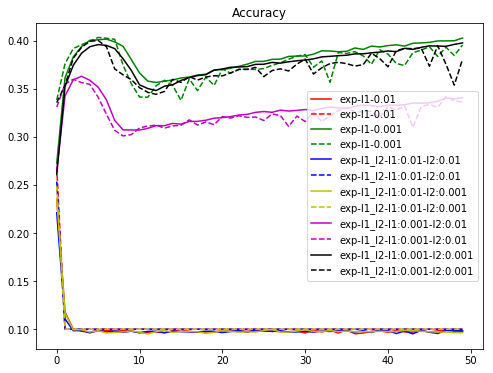

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()